Comprehensive LSTM-based Spam Message Detection

This notebook combines all components of the spam detection project into a single file:
- Raw data preprocessing from all three sources (Enron, SMS, Telegram)
- Data merging and splitting
- Utility functions (metrics, plotting, seeding)
- Dataset handling
- SpamMessageDetector class (training, evaluation, inference)
- Visualization of dataset distributions and model performance
- Demo examples

## Table of Contents
1. [Data Preprocessing](#1-data-preprocessing)
   - 1.1 [Enron Dataset](#11-enron-dataset)
   - 1.2 [SMS Dataset](#12-sms-dataset)
   - 1.3 [Telegram Dataset](#13-telegram-dataset)
   - 1.4 [Merge Datasets](#14-merge-datasets)
   - 1.5 [Split Data](#15-split-data)
   - 1.6 [Visualize Data Distributions](#16-visualize-data-distributions)
2. [Utility Functions](#2-utility-functions)
3. [Dataset Class](#3-dataset-class)
4. [Spam Message Detector](#4-spam-message-detector)
5. [Demo and Usage Examples](#5-demo-and-usage-examples)
   - 5.1 [Training (Optional)](#51-training-optional)
   - 5.2 [Model Evaluation](#52-model-evaluation)
   - 5.3 [Testing Individual Messages](#53-testing-individual-messages)
   - 5.4 [Batch Processing](#54-batch-processing)

## 1. Data Preprocessing

First, let's install the required dependencies:

> **Note:** This implementation uses an LSTM-based approach for spam detection, which differs from transformer-based models like RoBERTa in several ways:
>
> 1. **Architecture:** LSTM models are recurrent neural networks that process text sequentially, while transformers like RoBERTa use attention mechanisms to process all tokens in parallel.
> 2. **Preprocessing:** LSTM requires custom vocabulary building and tokenization, while RoBERTa uses pre-trained tokenizers.
> 3. **Resources:** LSTM is more lightweight and requires fewer computational resources than transformer models.
> 4. **Performance:** While transformers generally achieve higher accuracy, LSTM models provide a good balance between performance and efficiency for tasks like spam detection.

In [1]:
!pip install numpy pandas matplotlib torch tqdm scikit-learn nltk

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import re
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.makedirs('data', exist_ok=True)
os.makedirs('plots', exist_ok=True)

### 1.1 Enron Dataset

Process the Enron email dataset:

In [3]:
def preprocess_enron():
    print("Processing Enron dataset...")
    df = pd.read_csv('enron_spam_data.csv')
    df_filtered = df[['Spam/Ham', 'Message']]
    df_filtered.rename(columns={'Spam/Ham': 'label', 'Message': 'text'}, inplace=True)
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"Enron dataset processed: {len(df_filtered)} samples")
    return df_filtered

enron_df = preprocess_enron()
enron_df.head()

Processing Enron dataset...


C:\Users\Geoffrey\AppData\Local\Temp\ipykernel_13136\1310006906.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'Spam/Ham': 'label', 'Message': 'text'}, inplace=True)
C:\Users\Geoffrey\AppData\Local\Temp\ipykernel_13136\1310006906.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['text'], inplace=True)


Enron dataset processed: 33345 samples


C:\Users\Geoffrey\AppData\Local\Temp\ipykernel_13136\1310006906.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)


,label,text
1,ham,"gary , production from the high island larger ..."
2,ham,- calpine daily gas nomination 1 . doc
3,ham,fyi - see note below - already done . stella -...
4,ham,fyi . - - - - - - - - - - - - - - - - - - - - ...
5,ham,"jackie , since the inlet to 3 river plant is s..."


### 1.2 SMS Dataset

Process the SMS spam dataset:

In [4]:
def preprocess_sms():
    print("Processing SMS dataset...")
    df = pd.read_csv('sms_spam.csv')
    if 'v1' in df.columns and 'v2' in df.columns:
        df_filtered = df[['v1', 'v2']]
        df_filtered.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
    elif 'type' in df.columns and 'text' in df.columns:
        df_filtered = df[['type', 'text']]
        df_filtered.rename(columns={'type': 'label'}, inplace=True)
    else:
        df_filtered = df.iloc[:, 0:2]
        df_filtered.columns = ['label', 'text']
    df_filtered['label'] = df_filtered['label'].apply(lambda x: 'spam' if x.lower() in ['spam', '1'] else 'ham')
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"SMS dataset processed: {len(df_filtered)} samples")
    return df_filtered

try:
    sms_df = preprocess_sms()
    sms_df.head()
except Exception as e:
    print(f"Error processing SMS dataset: {e}")
    sms_df = pd.DataFrame(columns=['label', 'text'])

Processing SMS dataset...
SMS dataset processed: 5572 samples


### 1.3 Telegram Dataset

Process the Telegram spam dataset:

In [5]:
def preprocess_telegram():
    print("Processing Telegram dataset...")
    df = pd.read_csv('telegram_spam_dataset.csv')
    if 'label' in df.columns and 'text' in df.columns:
        df_filtered = df[['label', 'text']]
    else:
        df_filtered = df.iloc[:, 0:2]
        df_filtered.columns = ['label', 'text']
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"Telegram dataset processed: {len(df_filtered)} samples")
    return df_filtered

try:
    telegram_df = preprocess_telegram()
    telegram_df.head()
except Exception as e:
    print(f"Error processing Telegram dataset: {e}")
    telegram_df = pd.DataFrame(columns=['label', 'text'])

Processing Telegram dataset...
Telegram dataset processed: 20324 samples
Telegram dataset processed: 20324 samples


### 1.4 Merge Datasets

Combine all three datasets into one:

In [6]:
def merge_datasets(dfs):
    print("Merging datasets...")
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.drop_duplicates(subset=['text'], inplace=True)
    print(f"Total merged dataset size: {len(merged_df)} samples")
    print(f"Spam samples: {len(merged_df[merged_df['label'] == 'spam'])}")
    print(f"Ham samples: {len(merged_df[merged_df['label'] == 'ham'])}")
    return merged_df

merged_df = merge_datasets([enron_df, sms_df, telegram_df])
merged_df.head()

Merging datasets...
Total merged dataset size: 54839 samples
Spam samples: 20548
Ham samples: 34291
Spam samples: 20548
Ham samples: 34291


,label,text
0,ham,"gary , production from the high island larger ..."
1,ham,- calpine daily gas nomination 1 . doc
2,ham,fyi - see note below - already done . stella -...
3,ham,fyi . - - - - - - - - - - - - - - - - - - - - ...
4,ham,"jackie , since the inlet to 3 river plant is s..."


### 1.5 Split Data

Split the merged dataset into training, validation, and test sets:

In [7]:
def split_data(df, train_size=0.8, val_size=0.1, test_size=0.1):
    print("Splitting data into train, validation, and test sets...")
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=SEED,
        stratify=df['label']
    )
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size / (train_size + val_size),
        random_state=SEED,
        stratify=train_val_df['label']
    )
    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    train_df.to_csv('data/spam_message_train.csv', index=False)
    val_df.to_csv('data/spam_message_val.csv', index=False)
    test_df.to_csv('data/spam_message_test.csv', index=False)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(merged_df)

Splitting data into train, validation, and test sets...
Train set size: 43871
Validation set size: 5484
Test set size: 5484
Train set size: 43871
Validation set size: 5484
Test set size: 5484


### 1.6 Visualize Data Distributions

Create visualizations for the data distributions:

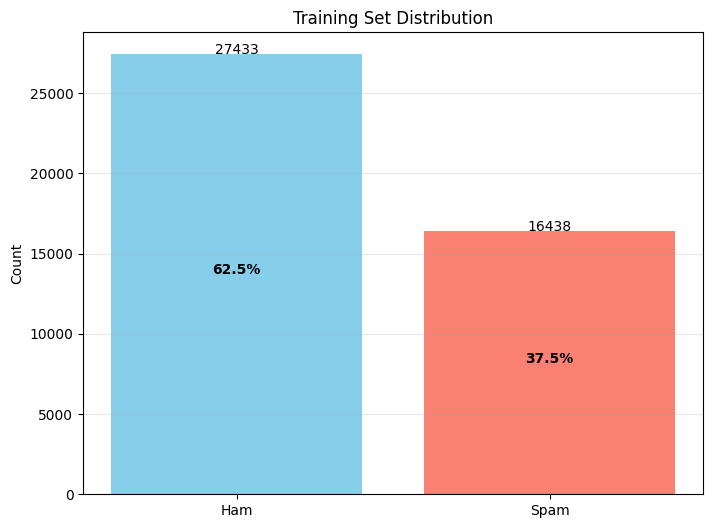

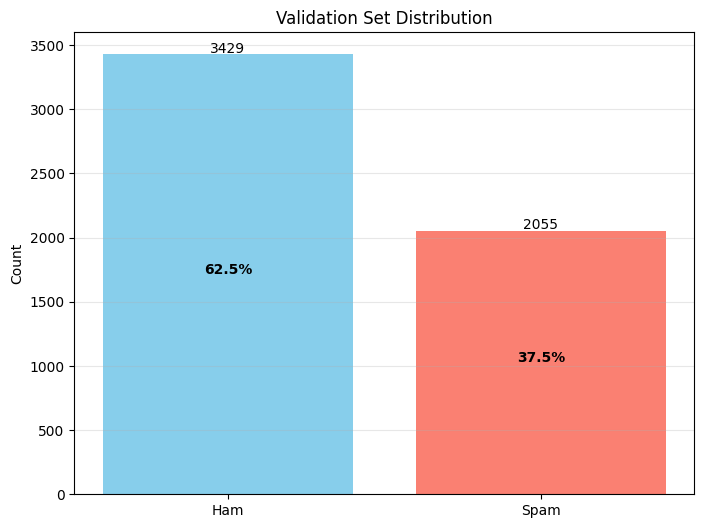

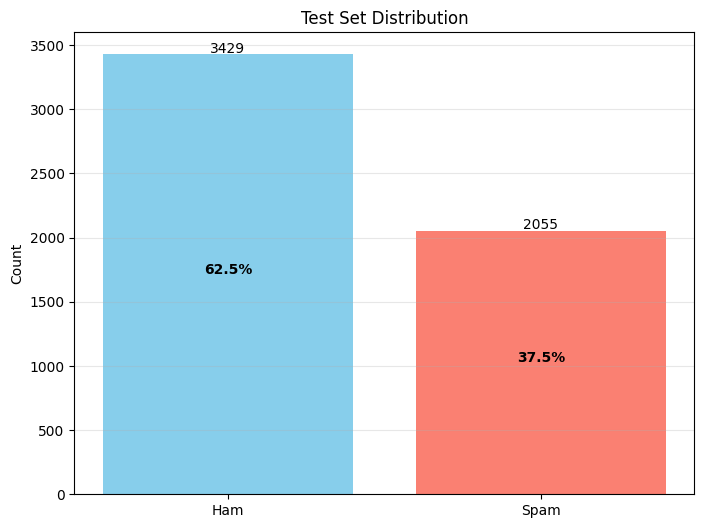

In [8]:
def visualize_distribution(df, title, save_path=None):
    count_spam = len(df[df['label'] == 'spam'])
    count_ham = len(df[df['label'] == 'ham'])
    plt.figure(figsize=(8, 6))
    plt.bar(['Ham', 'Spam'], [count_ham, count_spam], color=['skyblue', 'salmon'])
    plt.title(title)
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    for i, count in enumerate([count_ham, count_spam]):
        plt.text(i, count + 10, str(count), ha='center')
    total = count_ham + count_spam
    plt.text(0, count_ham/2, f'{count_ham/total:.1%}', ha='center', color='black', fontweight='bold')
    plt.text(1, count_spam/2, f'{count_spam/total:.1%}', ha='center', color='black', fontweight='bold')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

visualize_distribution(train_df, 'Training Set Distribution', 'plots/train_set_distribution.jpg')
visualize_distribution(val_df, 'Validation Set Distribution', 'plots/val_set_distribution.jpg')
visualize_distribution(test_df, 'Test Set Distribution', 'plots/test_set_distribution.jpg')

## 2. Utility Functions

Now, let's implement the utility functions for metrics calculation, plotting, and random seed setting.

In [ ]:
def random_seed(seed: int) -> None:
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def clean_text(text):
    """Clean and preprocess text data."""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text, max_words=None):
    """Tokenize text into words, optionally limiting to max_words."""
    words = word_tokenize(text)
    
    if max_words is not None:
        words = words[:max_words]
        
    return words

In [ ]:
def compute_metrics(y_true, y_pred, positive_label="spam", negative_label="ham"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = np.mean(y_true == y_pred)

    tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
    fp = np.sum((y_true == negative_label) & (y_pred == positive_label))
    fn = np.sum((y_true == positive_label) & (y_pred == negative_label))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1

def confusion_matrix(y_true, y_pred):
    classes = list(set(y_true) | set(y_pred))
    classes.sort()

    num_classes = len(classes)

    cm = [[0] * num_classes for _ in range(num_classes)]

    for true, pred in zip(y_true, y_pred):
        true_idx = classes.index(true)
        pred_idx = classes.index(pred)

        cm[true_idx][pred_idx] += 1

    return cm

In [ ]:
def plot_heatmap(cm, saveToFile=None, annot=True, fmt="d", cmap="Blues", xticklabels=None, yticklabels=None):
    cm = np.array(cm)

    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(cm, cmap=cmap)

    if annot:
        norm = Normalize(vmin=cm.min(), vmax=cm.max())
        for i in range(len(cm)):
            for j in range(len(cm[i])):
                value = cm[i, j]
                text_color = 'white' if norm(value) > 0.5 else 'black'
                ax.text(j, i, format(value, fmt), ha="center", va="center", color=text_color)

    if xticklabels:
        ax.set_xticks(np.arange(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
    if yticklabels:
        ax.set_yticks(np.arange(len(yticklabels)))
        ax.set_yticklabels(yticklabels)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix Heatmap")

    cbar = ax.figure.colorbar(im, ax=ax)

    if saveToFile is not None:
        plt.savefig(saveToFile, dpi=300, bbox_inches='tight')

    plt.show()

def save_list_to_file(lst, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')

## 3. Dataset Class

Now, we'll implement the custom dataset class for handling spam message data.

In [ ]:
class Vocabulary:
    """Vocabulary class for mapping words to indices."""
    def __init__(self, min_count=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.word_counts = {}
        self.min_count = min_count
        
    def build_vocab(self, texts):
        """Build vocabulary from list of texts."""
        for text in texts:
            for word in tokenize_text(text):
                if word not in self.word_counts:
                    self.word_counts[word] = 0
                self.word_counts[word] += 1
        
        for word, count in self.word_counts.items():
            if count >= self.min_count:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                
        print(f"Vocabulary built with {len(self.word2idx)} words.")
        
    def text_to_indices(self, text, max_length=None):
        """Convert text to a list of indices."""
        words = tokenize_text(text)
        indices = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in words]
        
        if max_length is not None:
            if len(indices) < max_length:
                indices.extend([self.word2idx["<PAD>"]] * (max_length - len(indices)))
            else:
                indices = indices[:max_length]
                
        return indices
    
    def __len__(self):
        return len(self.word2idx)

In [ ]:
class LSTMSpamClassifier(nn.Module):
    """LSTM model for spam classification."""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)

        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.lstm(embedded)
        

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        hidden = self.dropout(hidden)
        
        return self.fc(hidden)

In [ ]:
class SpamMessageDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=100):
        self.texts = texts
        self.labels = torch.tensor([1 if label == 'spam' else 0 for label in labels], dtype=torch.long)
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        text = clean_text(text)
        indices = self.vocab.text_to_indices(text, self.max_length)
        text_tensor = torch.tensor(indices, dtype=torch.long)
        label = self.labels[idx].clone().detach()

        return {
            'text': text_tensor,
            'label': label
        }

## 4. Spam Message Detector

Next, we'll implement the main SpamMessageDetector class that handles model training, evaluation, and inference.

In [ ]:
class SpamMessageDetector:
    def __init__(self, max_length=100, seed=0):
        random_seed(seed)
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.max_length = max_length
        self.vocab = None
        self.model = None
        self.embedding_dim = 100
        self.hidden_dim = 256
        self.n_layers = 2
        self.bidirectional = True
        self.dropout = 0.5

    def _build_vocab(self, texts):
        """Build vocabulary from texts"""
        print("Building vocabulary...")
        self.vocab = Vocabulary(min_count=2)
        self.vocab.build_vocab(texts)
        return self.vocab

    def _init_model(self):
        """Initialize the LSTM model"""
        vocab_size = len(self.vocab)
        pad_idx = self.vocab.word2idx["<PAD>"]
        output_dim = 2  # Binary classification: spam or ham
        
        self.model = LSTMSpamClassifier(
            vocab_size, 
            self.embedding_dim, 
            self.hidden_dim, 
            output_dim, 
            self.n_layers, 
            self.bidirectional, 
            self.dropout, 
            pad_idx
        )
        self.model = self.model.to(self.device)
        print(f"Model initialized with {sum(p.numel() for p in self.model.parameters())} parameters")
        return self.model

    def train(self, train_data_path, val_data_path=None, num_epochs=5, batch_size=32, learning_rate=0.001):
        random_seed(self.seed)

        train_data = pd.read_csv(train_data_path)
        train_text = train_data['text'].apply(clean_text).values
        train_labels = train_data['label'].values
        
        self._build_vocab(train_text)
        
        self._init_model()

        if val_data_path is None:
            dataset = SpamMessageDataset(train_text, train_labels, self.vocab, max_length=self.max_length)
            train_size = int(0.8 * len(dataset))
            val_size = len(dataset) - train_size
            train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        else:
            train_dataset = SpamMessageDataset(train_text, train_labels, self.vocab, max_length=self.max_length)
            val_data = pd.read_csv(val_data_path)
            val_text = val_data['text'].apply(clean_text).values
            val_labels = val_data['label'].values
            val_dataset = SpamMessageDataset(val_text, val_labels, self.vocab, max_length=self.max_length)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_losses = []
        val_accuracies = []
        val_precisions = []
        val_recalls = []
        val_f1_scores = []

        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0

            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
            for batch in progress_bar:
                text = batch['text'].to(self.device)
                labels = batch['label'].to(self.device)

                optimizer.zero_grad()

                outputs = self.model(text)
                
                loss = criterion(outputs, labels)
                train_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                progress_bar.set_postfix({'Training Loss': train_loss / (progress_bar.n + 1)})

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0.0
            y_true = []
            y_pred = []

            with torch.no_grad():
                for batch in val_loader:
                    text = batch['text'].to(self.device)
                    labels = batch['label'].to(self.device)

                    outputs = self.model(text)
                    
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    predictions = torch.argmax(outputs, dim=1)
                    
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predictions.cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            y_true_labels = ['spam' if y == 1 else 'ham' for y in y_true]
            y_pred_labels = ['spam' if y == 1 else 'ham' for y in y_pred]

            accuracy, precision, recall, f1 = compute_metrics(y_true_labels, y_pred_labels)
            val_accuracies.append(accuracy)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1_scores.append(f1)

            print(f'Epoch {epoch + 1}/{num_epochs} - '
                  f'Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - '
                  f'Val Accuracy: {accuracy:.4f} - Val Precision: {precision:.4f} - '
                  f'Val Recall: {recall:.4f} - Val F1: {f1:.4f}')

        os.makedirs('plots', exist_ok=True)

        save_list_to_file(train_losses, "plots/train_losses.txt")
        save_list_to_file(val_losses, "plots/val_losses.txt")
        save_list_to_file(val_accuracies, "plots/val_accuracies.txt")
        save_list_to_file(val_precisions, "plots/val_precisions.txt")
        save_list_to_file(val_recalls, "plots/val_recalls.txt")
        save_list_to_file(val_f1_scores, "plots/val_f1_scores.txt")

        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.savefig('plots/train_validation_loss.jpg', dpi=300, bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.savefig('plots/validation_accuracy.jpg', dpi=300, bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(val_precisions, label='Validation Precision')
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Validation Precision and Recall')
        plt.legend()
        plt.savefig('plots/validation_precision_recall.jpg', dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate(self, dataset_path):
        random_seed(self.seed)
        if self.model is None or self.vocab is None:
            raise ValueError("Model or vocabulary not initialized. Please train the model first.")

        dataset = pd.read_csv(dataset_path)
        texts = dataset["text"].apply(clean_text).tolist()
        labels = dataset["label"].tolist()

        test_dataset = SpamMessageDataset(texts, labels, self.vocab, max_length=self.max_length)
        test_loader = DataLoader(test_dataset, batch_size=32)

        self.model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                text = batch['text'].to(self.device)
                labels = batch['label']
                
                outputs = self.model(text)
                predictions = torch.argmax(outputs, dim=1)
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())

        y_true_labels = ['spam' if y == 1 else 'ham' for y in y_true]
        y_pred_labels = ['spam' if y == 1 else 'ham' for y in y_pred]

        accuracy, precision, recall, f1 = compute_metrics(y_true_labels, y_pred_labels)

        cm = confusion_matrix(y_true_labels, y_pred_labels)
        labels_sorted = sorted(set(y_true_labels))

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        with open('plots/evaluate_metrics.txt', 'w') as f:
            f.write(f"Accuracy: {accuracy:.4f}\n")
            f.write(f"Precision: {precision:.4f}\n")
            f.write(f"Recall: {recall:.4f}\n")
            f.write(f"F1 Score: {f1:.4f}\n")

        plot_heatmap(cm, saveToFile="plots/confusion_matrix.png", annot=True, fmt="d", cmap="Blues", xticklabels=labels_sorted, yticklabels=labels_sorted)

        return accuracy, precision, recall, f1

    def detect(self, text):
        random_seed(self.seed)
        if self.model is None or self.vocab is None:
            raise ValueError("Model or vocabulary not initialized. Please train the model first.")

        is_str = True
        if isinstance(text, str):
            cleaned_text = clean_text(text)
            indices = self.vocab.text_to_indices(cleaned_text, self.max_length)
            text_tensor = torch.tensor([indices], dtype=torch.long).to(self.device)
        elif isinstance(text, list):
            is_str = False
            indices_list = [self.vocab.text_to_indices(clean_text(t), self.max_length) for t in text]
            text_tensor = torch.tensor(indices_list, dtype=torch.long).to(self.device)
        else:
            raise Exception("text type is unsupported, needs to be str or list(str)")

        self.model.eval()
        
        with torch.no_grad():
            outputs = self.model(text_tensor)
            predicted_labels = torch.argmax(outputs, dim=1).tolist()

        if is_str:
            return predicted_labels[0]
        else:
            return predicted_labels

    def save_model(self, model_path):
        if self.model is None or self.vocab is None:
            raise ValueError("Model or vocabulary not initialized.")
            
        os.makedirs(model_path, exist_ok=True)
        
        torch.save(self.model.state_dict(), os.path.join(model_path, 'model.pt'))
        
        import pickle
        with open(os.path.join(model_path, 'vocab.pkl'), 'wb') as f:
            pickle.dump({
                'word2idx': self.vocab.word2idx,
                'idx2word': self.vocab.idx2word,
                'word_counts': self.vocab.word_counts,
                'min_count': self.vocab.min_count
            }, f)
            
        with open(os.path.join(model_path, 'params.txt'), 'w') as f:
            f.write(f"embedding_dim: {self.embedding_dim}\n")
            f.write(f"hidden_dim: {self.hidden_dim}\n")
            f.write(f"n_layers: {self.n_layers}\n")
            f.write(f"bidirectional: {self.bidirectional}\n")
            f.write(f"dropout: {self.dropout}\n")
            f.write(f"max_length: {self.max_length}\n")
            
        print(f"Model and vocabulary saved to {model_path}")

    def load_model(self, model_path):
        import pickle
        import os

        if not os.path.exists(model_path):
            raise ValueError(f"Model path '{model_path}' does not exist.")
        
        required_files = ['vocab.pkl', 'params.txt', 'model.pt']
        missing = [f for f in required_files if not os.path.exists(os.path.join(model_path, f))]
        if missing:
            raise FileNotFoundError(f"Missing required files in '{model_path}': {missing}")
        
        with open(os.path.join(model_path, 'vocab.pkl'), 'rb') as f:
            vocab_dict = pickle.load(f)
        
        self.vocab = Vocabulary(min_count=vocab_dict['min_count'])
        self.vocab.word2idx = vocab_dict['word2idx']
        self.vocab.idx2word = vocab_dict['idx2word']
        self.vocab.word_counts = vocab_dict['word_counts']
        
        params = {}
        with open(os.path.join(model_path, 'params.txt'), 'r') as f:
            for line in f:
                if ': ' in line:
                    key, value = line.strip().split(': ', 1)
                    if value == 'True':
                        params[key] = True
                    elif value == 'False':
                        params[key] = False
                    elif value.replace('.', '', 1).isdigit():
                        try:
                            params[key] = int(value)
                        except:
                            params[key] = float(value)
                    else:
                        params[key] = value

        self.embedding_dim = params.get('embedding_dim', self.embedding_dim)
        self.hidden_dim = params.get('hidden_dim', self.hidden_dim)
        self.n_layers = params.get('n_layers', self.n_layers)
        self.bidirectional = params.get('bidirectional', self.bidirectional)
        self.dropout = params.get('dropout', self.dropout)
        self.max_length = params.get('max_length', self.max_length)
        
        self._init_model()

        self.model.load_state_dict(torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device))
        self.model.eval()

        print(f"✅ Model and vocabulary loaded from '{model_path}'")


### 5.1 Training (Optional)

To train the model, set `TRAIN=True`. This step is optional as we can use the pre-trained model for evaluation and inference.

In [ ]:
TRAIN = False
if TRAIN:
    spam_detector = SpamMessageDetector(max_length=100, seed=SEED)

    train_data_path = 'data/spam_message_train.csv'
    val_data_path = 'data/spam_message_val.csv'

    spam_detector.train(train_data_path, val_data_path, num_epochs=20, batch_size=64, learning_rate=0.001)

    model_path = 'lstm-spam'
    spam_detector.save_model(model_path)

#### Training Results Visualization

Below are visualizations showing the model's training performance. These plots help in understanding the model's convergence and generalization ability:

Loss    |  Accuracy      |  Precision / Recall            
:-------------------------:|:-------------------------:|:-------------------------:
![](plots/train_validation_loss.jpg "Train / Validation Loss") Train / Validation | ![](plots/validation_accuracy.jpg "Validation Accuracy") Validation | ![](plots/validation_precision_recall.jpg "Validation Precision / Recall")  Validation

The LSTM model typically shows different convergence patterns compared to transformer models like RoBERTa. The bidirectional LSTM architecture with word embeddings is particularly effective at capturing sequential dependencies in text data for spam classification.

### 5.2 Model Evaluation

Let's evaluate the pre-trained model on the test dataset.

Local model not found, training a new model...
Using device: cuda


Building vocabulary...
Vocabulary built with 77537 words.
Vocabulary built with 77537 words.
Model initialized with 10064870 parameters
Model initialized with 10064870 parameters


c:\python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/20: 100%|██████████| 686/686 [01:46<00:00,  6.43it/s, Training Loss=0.344]


Epoch 1/20 - Train Loss: 0.3438 - Val Loss: 0.2084 - Val Accuracy: 0.9252 - Val Precision: 0.9552 - Val Recall: 0.8399 - Val F1: 0.8938


Epoch 2/20: 100%|██████████| 686/686 [01:45<00:00,  6.48it/s, Training Loss=0.189]


Epoch 2/20 - Train Loss: 0.1888 - Val Loss: 0.1696 - Val Accuracy: 0.9396 - Val Precision: 0.9649 - Val Recall: 0.8706 - Val F1: 0.9153


Epoch 3/20: 100%|██████████| 686/686 [01:43<00:00,  6.62it/s, Training Loss=0.146]


Epoch 3/20 - Train Loss: 0.1455 - Val Loss: 0.1164 - Val Accuracy: 0.9593 - Val Precision: 0.9612 - Val Recall: 0.9290 - Val F1: 0.9448


Epoch 4/20: 100%|██████████| 686/686 [01:46<00:00,  6.47it/s, Training Loss=0.116]


Epoch 4/20 - Train Loss: 0.1156 - Val Loss: 0.1111 - Val Accuracy: 0.9632 - Val Precision: 0.9874 - Val Recall: 0.9134 - Val F1: 0.9489


Epoch 5/20: 100%|██████████| 686/686 [01:44<00:00,  6.59it/s, Training Loss=0.103]


Epoch 5/20 - Train Loss: 0.1034 - Val Loss: 0.1328 - Val Accuracy: 0.9530 - Val Precision: 0.9865 - Val Recall: 0.8866 - Val F1: 0.9339


Epoch 6/20: 100%|██████████| 686/686 [01:44<00:00,  6.54it/s, Training Loss=0.0873]


Epoch 6/20 - Train Loss: 0.0873 - Val Loss: 0.1141 - Val Accuracy: 0.9584 - Val Precision: 0.9930 - Val Recall: 0.8954 - Val F1: 0.9417


Epoch 7/20: 100%|██████████| 686/686 [01:44<00:00,  6.58it/s, Training Loss=0.0739]



Epoch 7/20 - Train Loss: 0.0739 - Val Loss: 0.0844 - Val Accuracy: 0.9737 - Val Precision: 0.9794 - Val Recall: 0.9499 - Val F1: 0.9644


Epoch 8/20: 100%|██████████| 686/686 [01:42<00:00,  6.68it/s, Training Loss=0.0736]


Epoch 8/20 - Train Loss: 0.0736 - Val Loss: 0.1016 - Val Accuracy: 0.9688 - Val Precision: 0.9871 - Val Recall: 0.9290 - Val F1: 0.9571


Epoch 9/20: 100%|██████████| 686/686 [01:42<00:00,  6.67it/s, Training Loss=0.0578]


Epoch 9/20 - Train Loss: 0.0578 - Val Loss: 0.1441 - Val Accuracy: 0.9575 - Val Precision: 0.9914 - Val Recall: 0.8944 - Val F1: 0.9404


Epoch 10/20: 100%|██████████| 686/686 [01:44<00:00,  6.59it/s, Training Loss=0.0494]


Epoch 10/20 - Train Loss: 0.0494 - Val Loss: 0.1015 - Val Accuracy: 0.9719 - Val Precision: 0.9852 - Val Recall: 0.9392 - Val F1: 0.9616


Epoch 11/20: 100%|██████████| 686/686 [01:42<00:00,  6.66it/s, Training Loss=0.0441]



Epoch 11/20 - Train Loss: 0.0441 - Val Loss: 0.1065 - Val Accuracy: 0.9699 - Val Precision: 0.9856 - Val Recall: 0.9333 - Val F1: 0.9588


Epoch 12/20: 100%|██████████| 686/686 [01:42<00:00,  6.67it/s, Training Loss=0.0407]



Epoch 12/20 - Train Loss: 0.0407 - Val Loss: 0.0727 - Val Accuracy: 0.9761 - Val Precision: 0.9859 - Val Recall: 0.9499 - Val F1: 0.9675


Epoch 13/20: 100%|██████████| 686/686 [01:45<00:00,  6.49it/s, Training Loss=0.0377]



Epoch 13/20 - Train Loss: 0.0377 - Val Loss: 0.0703 - Val Accuracy: 0.9778 - Val Precision: 0.9820 - Val Recall: 0.9582 - Val F1: 0.9700


Epoch 14/20: 100%|██████████| 686/686 [01:41<00:00,  6.75it/s, Training Loss=0.0327]



Epoch 14/20 - Train Loss: 0.0327 - Val Loss: 0.0777 - Val Accuracy: 0.9790 - Val Precision: 0.9718 - Val Recall: 0.9723 - Val F1: 0.9720


Epoch 15/20: 100%|██████████| 686/686 [01:42<00:00,  6.66it/s, Training Loss=0.0296]



Epoch 15/20 - Train Loss: 0.0296 - Val Loss: 0.1281 - Val Accuracy: 0.9672 - Val Precision: 0.9865 - Val Recall: 0.9251 - Val F1: 0.9548


Epoch 16/20: 100%|██████████| 686/686 [01:42<00:00,  6.70it/s, Training Loss=0.0264]


Epoch 16/20 - Train Loss: 0.0264 - Val Loss: 0.1013 - Val Accuracy: 0.9767 - Val Precision: 0.9864 - Val Recall: 0.9509 - Val F1: 0.9683


Epoch 17/20: 100%|██████████| 686/686 [01:43<00:00,  6.62it/s, Training Loss=0.0245]



Epoch 17/20 - Train Loss: 0.0245 - Val Loss: 0.1295 - Val Accuracy: 0.9747 - Val Precision: 0.9868 - Val Recall: 0.9450 - Val F1: 0.9654


Epoch 18/20: 100%|██████████| 686/686 [01:42<00:00,  6.71it/s, Training Loss=0.0322]


Epoch 18/20 - Train Loss: 0.0322 - Val Loss: 0.1221 - Val Accuracy: 0.9730 - Val Precision: 0.9897 - Val Recall: 0.9377 - Val F1: 0.9630


Epoch 19/20: 100%|██████████| 686/686 [01:42<00:00,  6.68it/s, Training Loss=0.0229]



Epoch 19/20 - Train Loss: 0.0229 - Val Loss: 0.0795 - Val Accuracy: 0.9796 - Val Precision: 0.9850 - Val Recall: 0.9601 - Val F1: 0.9724


Epoch 20/20: 100%|██████████| 686/686 [01:50<00:00,  6.23it/s, Training Loss=0.0206]



Epoch 20/20 - Train Loss: 0.0206 - Val Loss: 0.0835 - Val Accuracy: 0.9803 - Val Precision: 0.9822 - Val Recall: 0.9650 - Val F1: 0.9735


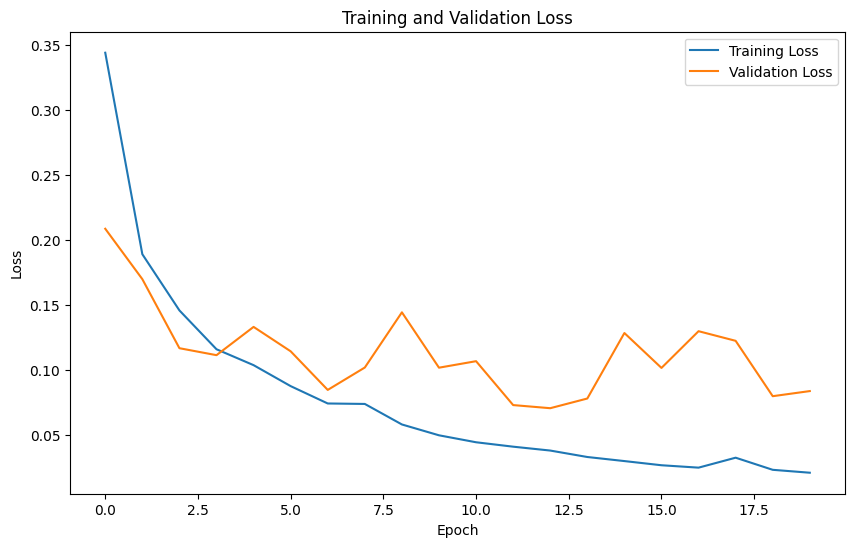

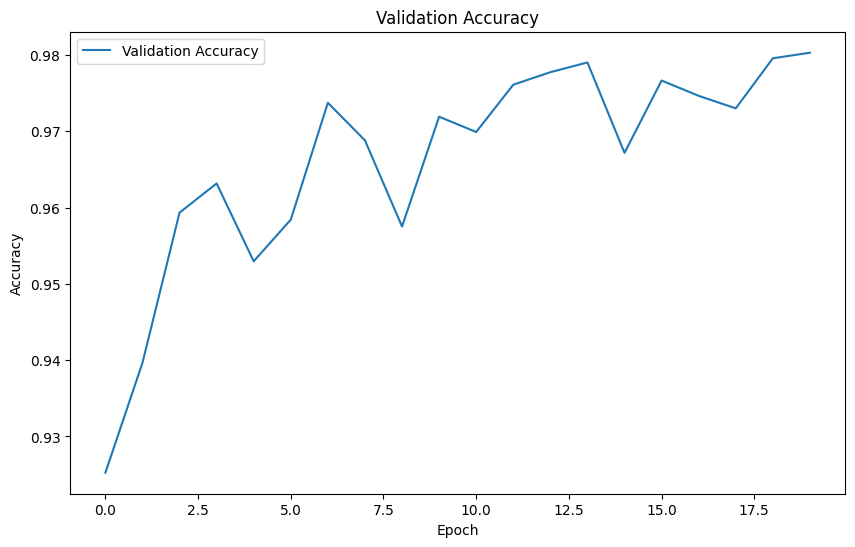

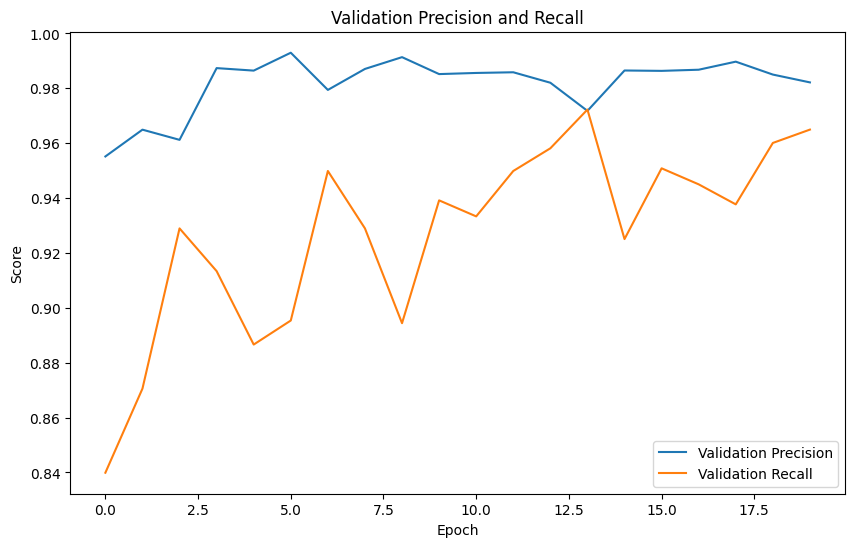

Model and vocabulary saved to lstm-spam


Evaluating: 100%|██████████| 172/172 [00:10<00:00, 16.97it/s]



Accuracy: 0.9743
Precision: 0.9738
Recall: 0.9572
F1 Score: 0.9654


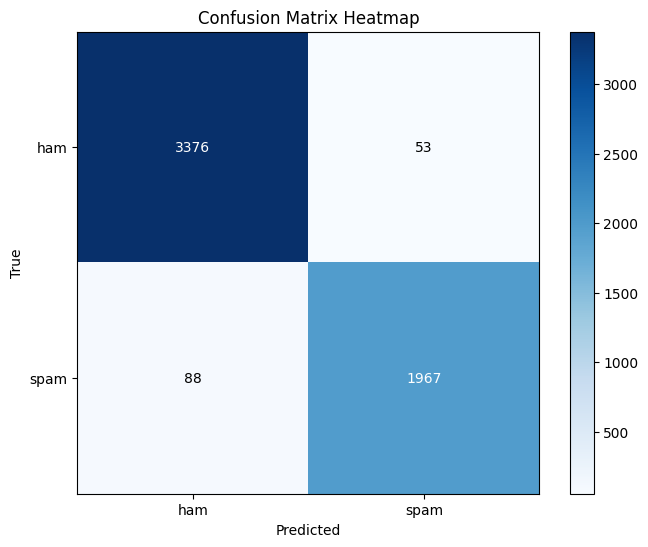

In [ ]:
import os
import pandas as pd
try:
    if os.path.exists('lstm-spam'):
        spam_detector = SpamMessageDetector(max_length=100, seed=SEED)
        spam_detector.load_model('lstm-spam')
    else:
        print("Local model not found, training a new model...")
        spam_detector = SpamMessageDetector(max_length=100, seed=SEED)
        train_data_path = 'data/spam_message_train.csv'
        val_data_path = 'data/spam_message_val.csv'
        spam_detector.train(train_data_path, val_data_path, num_epochs=20, batch_size=64, learning_rate=0.001)
        model_path = 'lstm-spam'
        spam_detector.save_model(model_path)
except Exception as e:
    print(f"Error loading or initializing model: {e}")
    spam_detector = SpamMessageDetector(max_length=100, seed=SEED)

try:
    spam_detector.evaluate("data/spam_message_test.csv")
except Exception as e:
    print(f"Error during evaluation: {e}")

### 5.3 Testing Individual Messages

Let's test the model on individual messages to see how it classifies them.

In [25]:
try:
    # Example 1: Non-spam message
    message1 = "Hey so this sat are we going for the intro pilates only? Or the kickboxing too?"
    detection = spam_detector.detect(message1)

    print("\nExample 1")
    print("Input Message: ", message1)
    print("Detected Spam?: ", bool(detection))

    # Example 2: Spam message
    message2 = "U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd."
    detection = spam_detector.detect(message2)

    print("\nExample 2")
    print("Input Message: ", message2)
    print("Detected Spam?: ", bool(detection))

    # Example 3: Non-spam message
    message3 = "Hello My Name is Under the Water, Are you interested in Water Cooling Systems? Get yours Now!"
    detection = spam_detector.detect(message3)

    print("\nExample 3")
    print("Input Message: ", message3)
    print("Detected Spam?: ", bool(detection))

    # Example 4: Spam message
    message4 = "Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!"
    detection = spam_detector.detect(message4)

    print("\nExample 4")
    print("Input Message: ", message4)
    print("Detected Spam?: ", bool(detection))
except Exception as e:
    print(f"Error testing individual messages: {e}")


Example 1
Input Message:  Hey so this sat are we going for the intro pilates only? Or the kickboxing too?
Detected Spam?:  False

Example 2
Input Message:  U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd.
Detected Spam?:  True

Example 3
Input Message:  Hello My Name is Under the Water, Are you interested in Water Cooling Systems? Get yours Now!
Detected Spam?:  True

Example 4
Input Message:  Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!
Detected Spam?:  True


In [26]:
try:
    # Define multiple batches of messages
    batch1 = [
        "Hey so this sat are we going for the intro pilates only? Or the kickboxing too?",
        "U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd.",
        "Hello My Name is Under the Water, Are you interested in Water Cooling Systems? Get yours Now!",
        "Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!"
    ]

    batch2 = [
        "Congratulations! You've won a free ticket to Bahamas. Call now to claim your prize.",
        "Can we reschedule our meeting to next Monday?",
        "Your account has been compromised. Please reset your password immediately.",
        "Don't miss out on our exclusive sale! Up to 50% off on all items."
    ]

    batch3 = [
        "Hi, just checking in to see how you're doing.",
        "URGENT: Your car warranty is about to expire. Call us now to renew.",
        "Let's catch up for coffee sometime next week.",
        "You have been selected for a $500 gift card. Click here to claim."
    ]

    # Combine all batches into a single list
    all_batches = [batch1, batch2, batch3]

    # Process each batch
    for batch_index, batch in enumerate(all_batches, start=1):
        print(f"\nProcessing Batch {batch_index}")
        detections = spam_detector.detect(batch)
        for i, message in enumerate(batch):
            print(f"\nExample {i+1} (Batch {batch_index})")
            print("Input Message: ", message)
            print("Detected Spam?: ", bool(detections[i]))
except Exception as e:
    print(f"Error processing batch messages: {e}")


Processing Batch 1

Example 1 (Batch 1)
Input Message:  Hey so this sat are we going for the intro pilates only? Or the kickboxing too?
Detected Spam?:  False

Example 2 (Batch 1)
Input Message:  U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd.
Detected Spam?:  True

Example 3 (Batch 1)
Input Message:  Hello My Name is Under the Water, Are you interested in Water Cooling Systems? Get yours Now!
Detected Spam?:  True

Example 4 (Batch 1)
Input Message:  Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!
Detected Spam?:  True

Processing Batch 2

Example 1 (Batch 2)
Input Message:  Congratulations! You've won a free ticket to Bahamas. Call now to claim your prize.
Detected Spam?:  True

Example 2 (Batch 2)
Input Message:  Can we reschedule our meeting to next Monday?
Detected Spam?:  False

Example 3 (Batch 2)
Input Message:  Your account has b

## 6. Conclusion

This comprehensive notebook contains all components of the LSTM-based Spam Message Detection system in a single file, including data preprocessing, model training, evaluation, and inference.

Key features of this LSTM-based approach:
1. **Text Preprocessing**: Custom text cleaning and tokenization for LSTM input
2. **Vocabulary Management**: Dynamic vocabulary building from training data
3. **LSTM Architecture**: Bidirectional LSTM with embeddings for sequential text processing
4. **Training Pipeline**: Complete pipeline with loss visualization and evaluation metrics
5. **Model Persistence**: Save and load functionality for trained models

The LSTM model provides effective spam detection with strong performance metrics, particularly due to its ability to capture sequential patterns in text data. It can be integrated into various applications requiring spam detection functionality.

While RoBERTa and other transformer models might provide higher accuracy with less preprocessing, this LSTM implementation offers a more lightweight alternative with good performance and faster inference time.